Este algoritmo fue presentado por **Ethan Rublee, Vincent Rabaud, Kurt Konolige y Gary R. Bradski** en su artículo *"ORB: An efficient alternative to SIFT or SURF"*, publicado en 2011.

Como su título indica, ORB es una buena alternativa a **SIFT y SURF** en cuanto a:

- 💰 **Coste computacional**
- 🎯 **Rendimiento en emparejamiento**
- ⚖️ **Y lo más importante: no está patentado**

Tanto SIFT como SURF están **protegidos por patentes**, y se requiere **pago para su uso comercial**.  
En cambio, ¡**ORB es libre**!


🔍 **¿Qué es ORB?**

ORB es básicamente una combinación de:

- 🔹 **FAST** como detector de puntos clave  
- 🔹 **BRIEF** como descriptor  

...con varias **mejoras** para aumentar su rendimiento y robustez.


📌 **Funcionamiento básico de ORB**

1. ORB usa **FAST** para detectar puntos clave (*keypoints*).
2. Luego aplica una **medida de esquina tipo Harris** para seleccionar los **mejores N puntos**.
3. Utiliza una **pirámide de imágenes** para generar características a múltiples escalas.

❗ FAST no calcula orientación, entonces...  
**¿Cómo logra ORB invariancia a la rotación?**


🧭 **Invariancia a la rotación**

Los autores propusieron una solución:

- Se calcula el **centroide ponderado por intensidad** del parche alrededor del punto.
- El vector desde el punto clave hasta el centroide define la **orientación**.
- Para mejorar esta invariancia, se calculan **momentos** dentro de una región **circular**, cuyo radio depende del tamaño del parche.


🧬 **Descriptores: rBRIEF**

ORB utiliza los descriptores **BRIEF**, pero como BRIEF funciona mal con rotaciones, ORB lo mejora **rotando ("steering") BRIEF** según la **orientación del keypoint**.

Pasos:

- Se definen una serie de **tests binarios** con coordenadas dentro del parche.
- Se calcula la **matriz de rotación** usando la orientación del punto.
- Se rotan los tests para adaptarlos a la dirección del keypoint → así se obtiene **rBRIEF**.

ORB discretiza la orientación en **incrementos de 12 grados** y crea una **tabla de patrones BRIEF precomputados**.  
Mientras la orientación sea consistente, se usará el patrón correcto para describir cada punto clave.


📊 **Propiedades de rBRIEF**

- BRIEF original tiene **alta varianza** y una **media cercana a 0.5** → ideal para distinguir patrones.
- Al ser rotado (rBRIEF), puede **perder estas propiedades**.

Para resolverlo, ORB realiza una **búsqueda codiciosa** para seleccionar los mejores tests binarios que cumplan:

- Alta varianza
- Media ≈ 0.5
- Mínima correlación entre tests

🔍 Esto hace que los descriptores generados sean **más discriminativos y robustos**.


### Paso 1: Carga y visualización de la imagen  
Después de la importación de las librerías necesarias, primero cargamos una imagen de prueba y la convertimos a escala de grises. Esto es necesario porque ORB trabaja sobre intensidades, no colores.


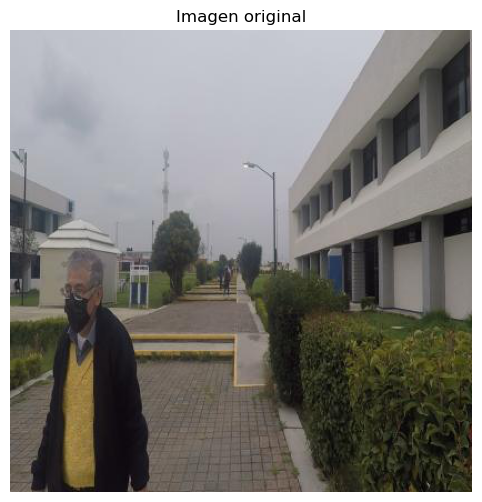

In [7]:
from algoritmos.orb import ORB_Detector
import cv2
import matplotlib.pyplot as plt

# Ruta a la imagen de prueba
image_path = '../src/images/test/GOPR0141_MP4-195_jpg.rf.5ed66cd884da63e15b570f0db8d88740.jpg'

# Inicializar detector ORB
orb_detector = ORB_Detector(nfeatures=500)

# Cargar imagen y convertir a escala de grises
img, gray = orb_detector.load_image(image_path)
orb_detector.show_image(img, "Imagen original")

### 📐 Paso adicional: Suavizado y pirámide de escalas en ORB

ORB, al igual que otros detectores multiescala como SIFT o SURF, utiliza una **pirámide de escalas** para analizar la imagen a diferentes resoluciones. Esto permite detectar características **invariantes a escala**, es decir, que puedan ser detectadas aunque el objeto aparezca más grande o más pequeño en la imagen.

Para ello, ORB aplica:
- ✅ Un **suavizado Gaussiano** a cada nivel para reducir el ruido.
- ✅ Un escalado sucesivo de la imagen (por ejemplo, reduciendo a la mitad su resolución en cada nivel).

Esto permite detectar keypoints robustos y estables en diferentes niveles de detalle. El suavizado también ayuda a evitar la detección de esquinas falsas debido a ruido o texturas muy finas.


### 🧠 ¿Qué es un filtro Gaussiano y por qué se usa en ORB?

Un filtro Gaussiano es un tipo de **suavizado** que reduce el ruido y los detalles pequeños de la imagen. Funciona aplicando una máscara en forma de campana de Gauss (distribución normal) sobre los píxeles vecinos.

#### Fórmula del filtro Gaussiano en 2D:
$$
G(x, y, \sigma) = \frac{1}{2\pi\sigma^2} \exp\left(-\frac{x^2 + y^2}{2\sigma^2}\right)
$$

Donde:
- $\sigma$ es la desviación estándar del filtro (cuanto mayor, más difumina).
- $x$ y $y$ son las coordenadas relativas al centro del filtro.

🔍 Este filtro se aplica antes de detectar keypoints en cada nivel de la pirámide, ayudando a que los puntos detectados sean más **estables y consistentes**, reduciendo el impacto del ruido o de los pequeños detalles que podrían generar keypoints falsos.


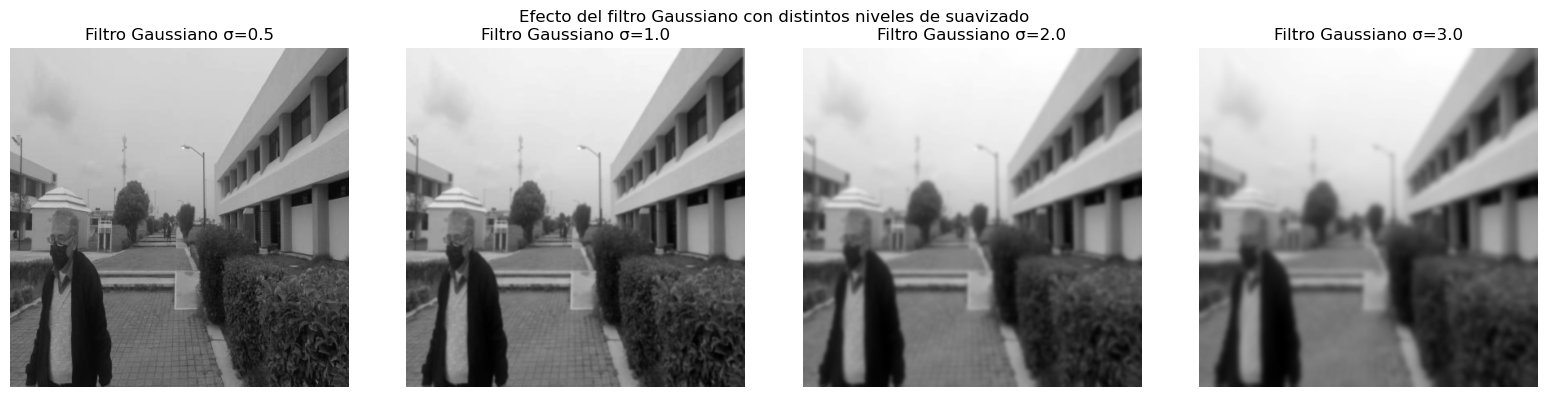

In [8]:
sigmas = [0.5, 1.0, 2.0, 3.0]
fig, axes = plt.subplots(1, len(sigmas), figsize=(16, 4))

for i, sigma in enumerate(sigmas):
    blurred = cv2.GaussianBlur(gray, (0, 0), sigma)
    axes[i].imshow(blurred, cmap='gray')
    axes[i].set_title(f'Filtro Gaussiano σ={sigma}')
    axes[i].axis('off')

plt.suptitle('Efecto del filtro Gaussiano con distintos niveles de suavizado')
plt.tight_layout()
plt.show()

# **🔹 Pirámide de escalas**
 
Para lograr invariancia a escala, ORB aplica una pirámide de imágenes. Esto significa que la imagen original se reduce varias veces, creando versiones más pequeñas a diferentes niveles de resolución.
 
 En cada nivel:
 - Se detectan keypoints independientes, permitiendo encontrar características grandes o pequeñas.
 - Se aplica un filtro gaussiano para reducir ruido.
 
 El objetivo es que el algoritmo pueda detectar los mismos puntos clave aunque el objeto aparezca más cerca o más lejos (más grande o más pequeño).
 
 Este enfoque multiescala permite que los descriptores sean más robustos y consistentes, especialmente en tareas donde los objetos cambian de tamaño en la imagen.
 
 ORB aplica una pirámide para detectar keypoints robustos a cambios de escala.

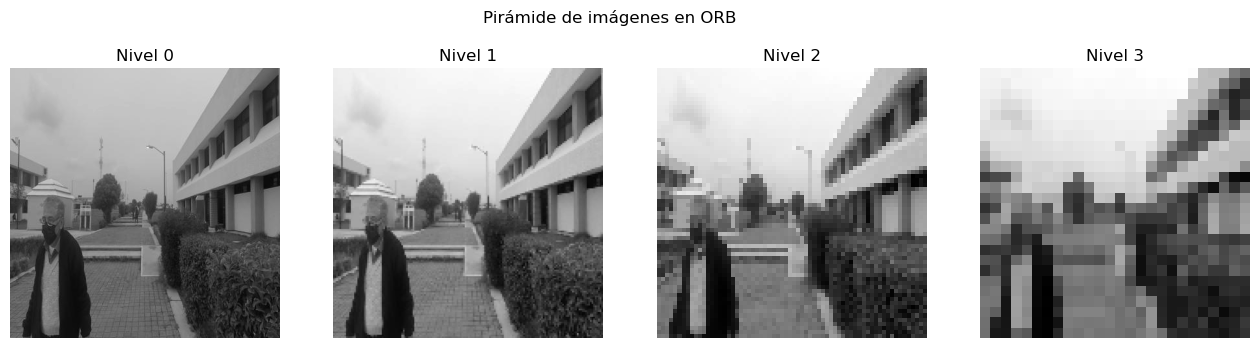

In [9]:
pyramid = orb_detector.build_image_pyramid(gray, n_levels=4, scale_factor=2.5)
fig, axes = plt.subplots(1, len(pyramid), figsize=(16, 4))
for i, level in enumerate(pyramid):
    axes[i].imshow(level, cmap='gray')
    axes[i].set_title(f'Nivel {i}')
    axes[i].axis('off')
plt.suptitle("Pirámide de imágenes en ORB")
plt.show()

### Paso 2: Detección de puntos clave con FAST  
ORB utiliza el detector FAST para localizar esquinas en la imagen. Esta técnica es muy rápida pero no calcula orientación ni filtra por calidad.  
En este paso solo localizamos posiciones iniciales de keypoints.


Número de keypoints detectados (FAST): 2714


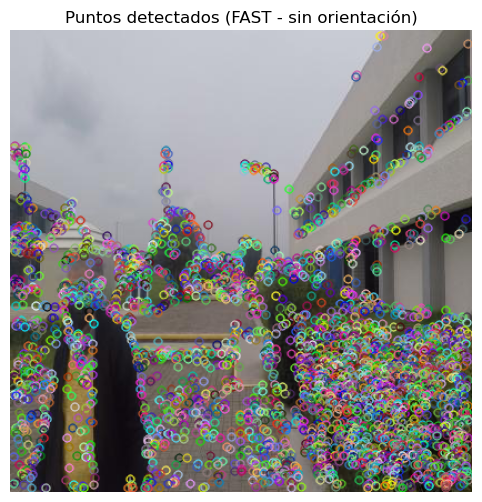

In [10]:
fast = cv2.FastFeatureDetector_create()
keypoints = fast.detect(gray, None)
print(f"Número de keypoints detectados (FAST): {len(keypoints)}")

img_fast = orb_detector.draw_keypoints(img, keypoints)
orb_detector.show_image(img_fast, "Puntos detectados (FAST - sin orientación)")

### Paso 3: Filtrado con respuesta de Harris  
ORB mejora los keypoints de FAST evaluando la "fuerza de esquina" con el detector de Harris. Esto permite eliminar puntos débiles o poco significativos.


Keypoints tras filtrado Harris: 259


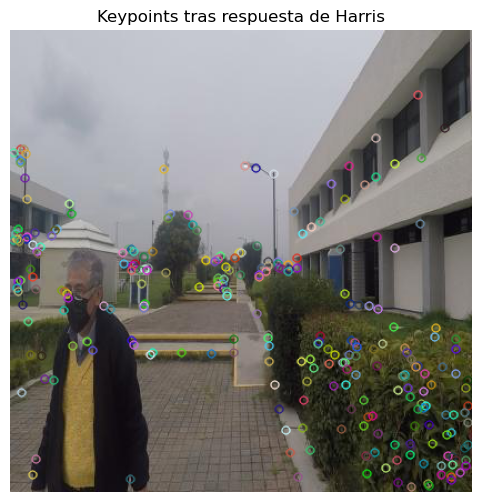

In [11]:
keypoints = orb_detector.compute_harris_response(gray, keypoints)
print("Keypoints tras filtrado Harris:", len(keypoints))

img_harris = orb_detector.draw_keypoints(img, keypoints)
orb_detector.show_image(img_harris, "Keypoints tras respuesta de Harris")

 # **📐 Asignación de orientación a los keypoints**
 ## ORB asigna una orientación dominante a cada keypoint usando momentos. Esto permite invariancia a rotaciones.

 # **🔍 ¿Qué es un parche de imagen y cómo se obtiene?**
 
 Un **parche** es una pequeña región rectangular centrada alrededor de un punto clave (keypoint). Se extrae de la imagen en escala de grises y contiene información local relevante que se usará para calcular orientación o descriptores.
 
 Generalmente, el parche tiene un tamaño fijo (por ejemplo, 31x31 píxeles) y se obtiene así:
 
 - Se toma el punto clave $(x, y)$ como centro.
 - Se extrae una región cuadrada de tamaño $(w, h)$ alrededor de ese punto: $(x - w/2, y - h/2)$ hasta $(x + w/2, y + h/2)$.
 
 Este parche se usa tanto para:
 - Calcular momentos y asignar orientación.
 - Aplicar el descriptor BRIEF rotado (rBRIEF).
 
 El parche permite capturar el contexto visual inmediato del punto clave, manteniendo la invariancia a traslaciones pequeñas, escalas y rotaciones.
 
 ORB asigna una orientación dominante a cada keypoint usando momentos. Esto permite invariancia a rotaciones.

In [12]:
# Visualización del keypoint seleccionado y su parche asociado
kp = keypoints_harris[0]
x, y = int(kp.pt[0]), int(kp.pt[1])
patch_size = 31
x0, y0 = max(x - patch_size // 2, 0), max(y - patch_size // 2, 0)
x1, y1 = min(x + patch_size // 2, gray.shape[1]), min(y + patch_size // 2, gray.shape[0])
patch = gray[y0:y1, x0:x1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Imagen original con el keypoint marcado
img_kp = img.copy()
cv2.circle(img_kp, (x, y), radius=5, color=(0, 255, 0), thickness=2)
ax1.imshow(cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB))
ax1.set_title("Keypoint seleccionado")
ax1.axis("off")

# Parche extraído del keypoint
ax2.imshow(patch, cmap='gray')
ax2.set_title("Parche centrado en el keypoint")
ax2.axis("off")

plt.tight_layout()
plt.show()


NameError: name 'keypoints_harris' is not defined

 # **🧠 ¿Qué son los momentos de imagen?**

 Los momentos son medidas estadísticas que resumen la distribución espacial de la intensidad de píxeles.
 ORB utiliza los **momentos espaciales** para calcular el **centroide** de un parche de imagen.

 - **Momento espacial:**
    
    $\displaystyle M_{pq} = \sum_x \sum_y x^p y^q I(x, y)$

 - **Centroide:**
    
    $\displaystyle cx = \frac{M_{10}}{M_{00}}, \quad cy = \frac{M_{01}}{M_{00}}$
 
 - **Orientación dominante:**
 
    $\displaystyle \theta = \arctan2\left(cy - \frac{h}{2}, cx - \frac{w}{2}\right)$

 Donde \( (w, h) \) son las dimensiones del parche. La orientación se define como el ángulo entre
  el centro del parche y su centroide ponderado por intensidad.

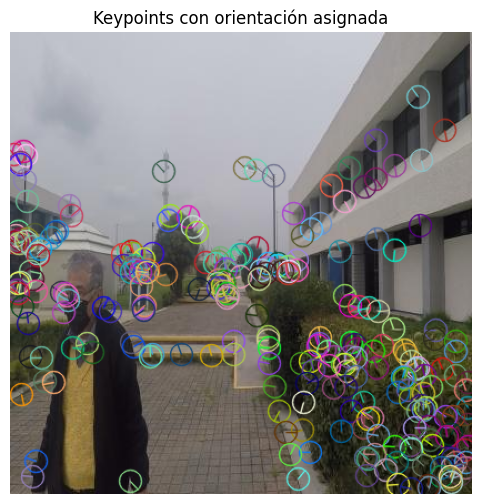

In [ ]:
keypoints_oriented = orb_detector.assign_orientation(keypoints_harris, gray)
for kp in keypoints_oriented:
    kp.size = 20  # aumentar tamaño para visualización
img_oriented = orb_detector.draw_keypoints(img, keypoints_oriented)
orb_detector.show_image(img_oriented, "Keypoints con orientación asignada")

**🧩 Cálculo de descriptores rBRIEF**

ORB calcula descriptores binarios rotados basados en BRIEF, ajustados a la orientación.

### 🧠 ¿Cómo funciona BRIEF?

BRIEF (Binary Robust Independent Elementary Features) representa un parche de imagen como un vector binario.
Este vector se obtiene a partir de comparaciones de intensidad entre pares de píxeles dentro del parche:

$$
\text{Si } I(p_1) < I(p_2), \text{ entonces se guarda un bit 1} \\\\
\text{Si } I(p_1) \geq I(p_2), \text{ entonces se guarda un bit 0}
$$

Esto se hace cientos de veces (por ejemplo, 256), generando un vector binario único para cada keypoint.

### 🔄 ¿Qué aporta ORB a BRIEF?

BRIEF no es invariante a rotaciones, por lo que ORB **rota** el conjunto de pruebas (pares de píxeles) usando la orientación asignada al keypoint.
Esto produce el descriptor **rBRIEF** (*rotated BRIEF*).

Además, ORB selecciona cuidadosamente qué pares de píxeles comparar, priorizando aquellos que:
- Tienen alta varianza (aportan más información).
- Son poco correlacionados entre sí (más independientes).

✅ El resultado es un descriptor binario rápido, robusto y especialmente útil para dispositivos móviles o tareas en tiempo real.


Tamaño matriz de descriptores: (187, 32)


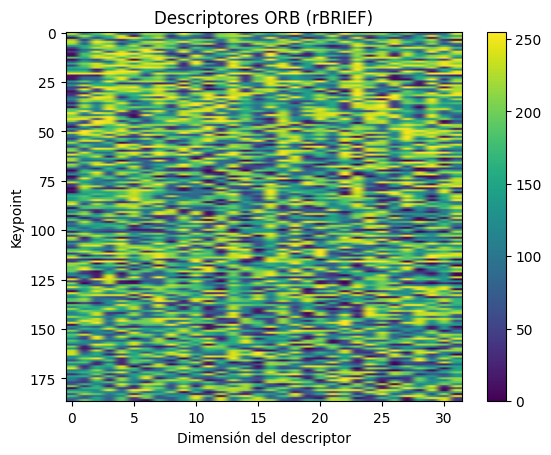

In [ ]:
keypoints_final, descriptors = orb_detector.compute_descriptors(gray, keypoints_oriented)
print("Tamaño matriz de descriptores:", descriptors.shape)
plt.imshow(descriptors, aspect='auto', cmap='viridis')
plt.title("Descriptores ORB (rBRIEF)")
plt.xlabel("Dimensión del descriptor")
plt.ylabel("Keypoint")
plt.colorbar()
plt.show()

In [ ]:
from machine_learning.svm import svm
from algoritmos.orb import ORB_Detector
from utils.orb_svm import orb_svm
import os

In [ ]:
parametros_orb = {"nfeatures": 500}
clasificador = svm(algorithm=orb_svm, algo_params=parametros_orb, tipo=1)

carpeta_personas = "images/train"
carpeta_no_personas = "images/train_no"
carpeta_test_personas = "images/test"
carpeta_test_no_personas = "images/test_no"

In [ ]:
imagenes_invalidas = 0
for file in os.listdir(carpeta_personas):
    if file.endswith(".jpg"):
        xml_path = os.path.join(carpeta_personas, file.replace(".jpg", ".xml"))
        if os.path.exists(xml_path):
            image = cv2.imread(os.path.join(carpeta_personas, file), cv2.IMREAD_GRAYSCALE)
            if image is None or image.shape[0] < 10 or image.shape[1] < 10:
                print(f"❌ Imagen inválida o vacía: {file}")
                imagenes_invalidas += 1

print(f"🔍 Total imágenes inválidas detectadas: {imagenes_invalidas}")

NameError: name 'os' is not defined

In [ ]:
clasificador.fit(carpeta_personas, carpeta_no_personas)

Imágenes procesadas - Entrenamiento: 2574 personas, 2899 sin persona


In [ ]:
clasificador.save_model("svm_orb.pkl")


Modelo SVM guardado como 'svm_orb.pkl'


In [ ]:
clasificador.evaluate(carpeta_test_personas, carpeta_test_no_personas, model_path="svm_orb.pkl")

Imágenes procesadas - Evaluacion: 747 personas, 781 sin persona

Precisión del modelo en el conjunto de prueba: 75.39%
🔹 Precisión (Precision): 66.67%
🔹 Sensibilidad (Recall): 99.33%
🔹 F1-Score: 79.78%

Matriz de confusión:
[[410 371]
 [  5 742]]

Falsos positivos (FP): 371
Falsos negativos (FN): 5
Verdaderos positivos (TP): 742
Verdaderos negativos (TN): 410

Reporte de clasificación:
              precision    recall  f1-score   support

  No Persona       0.99      0.52      0.69       781
     Persona       0.67      0.99      0.80       747

    accuracy                           0.75      1528
   macro avg       0.83      0.76      0.74      1528
weighted avg       0.83      0.75      0.74      1528

